In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
!mkdir '/content/data/'

In [ ]:
!unzip '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge' -d '/content/data/'

Archive:  /content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/data/sample_submission.csv.zip  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/test_labels.csv.zip  
  inflating: /content/data/train.csv.zip  


In [ ]:
train=pd.read_csv("/content/data/train.csv.zip")
test=pd.read_csv("/content/data/test.csv.zip")

In [ ]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(train, test_size=0.2)

In [ ]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
837,02477578811d15a3,"""\nJust to clarify what I'm referring to in pa...",0,0,0,0,0,0
38338,665ec0e4fac795b8,"""\nPS I am a former admin. ΔT The only constant """,0,0,0,0,0,0
9002,17f07beb929d955d,The controversy surrounding this article is no...,0,0,0,0,0,0
123200,9316cf5f2a698539,"""ANBODY THAT RELIES ON WIKIPEDIA FOR INFORMATI...",0,0,0,0,0,0
153879,a45a79ceeab87fa6,So go ahead \n\nGo ahead and ban me then. She ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
117755,75189947e8389973,"""\n\nOkay, lets meet halfway on this. I propos...",0,0,0,0,0,0
97195,07fa6f3dadf48f61,Thanks \n\nThanks for the improvement of Born ...,0,0,0,0,0,0
106514,39c27b2f932eddf6,It looks like everything that preceded the las...,0,0,0,0,0,0
138390,e46805d4881786a9,I was doing amazing work and you know it. Sure...,0,0,0,0,0,0


In [ ]:
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
65506,af389a4d40be9e38,Are you satisfied? As I mentioned on the talk...,0,0,0,0,0,0
23014,3cd4e68fb6cd6332,Can't believe you bothered wasting your time o...,0,0,0,0,0,0
89395,ef23759818603b06,""": It's done: I updated the NDAA 2012 article ...",0,0,0,0,0,0
70607,bcf3e788c7790747,The anarchist approach to justice is not to ha...,0,0,0,0,0,0
109602,4a48cf4a5425f85b,The above pomposity was either temporarily or ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
43239,736a1576290bf13f,Archive it and forget about,0,0,0,0,0,0
53857,8fdd7776b07a0380,Thanks for messing with my scratchpad. Real ki...,0,0,0,0,0,0
12602,216d3c0bd9769204,"""\n\n Table size dispute on How the Earth Was ...",0,0,0,0,0,0
99873,1678448ef1354077,"Sigh! Eyesore, the trolls are really beginning...",0,0,0,0,0,0


In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

# Tokenizer

In [ ]:
list_tokenized_train[:1]

[[50,
  2,
  1846,
  40,
  74,
  1279,
  2,
  10,
  663,
  11,
  8,
  14,
  480,
  2,
  286,
  9,
  8,
  949,
  345,
  38]]

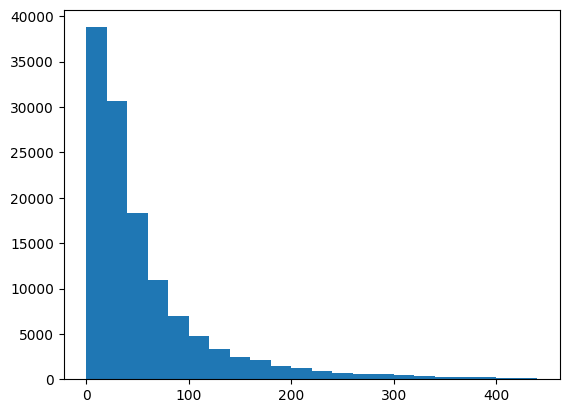

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,450,20))
plt.show()

In [ ]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
X_train.shape

(127656, 200)

In [ ]:
X_test.shape

(31915, 200)

# Model

In [ ]:
inp = Input(shape=(maxlen, ))

In [ ]:
#embedding
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [ ]:
#LSTM
x = GRU(64, return_sequences=True,name='gru_layer')(x)
x = LSTM(64, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 gru_layer (GRU)             (None, 200, 64)           37248     
                                                                 
 lstm_layer (LSTM)           (None, 200, 64)           33024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                             

# Training

In [ ]:
batch_size = 32
epochs = 5
h = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
3591/3591 [==============================] - 186s 48ms/step - loss: 0.0982 - accuracy: 0.9810 - val_loss: 0.0520 - val_accuracy: 0.9947
Epoch 2/5
3591/3591 [==============================] - 74s 21ms/step - loss: 0.0470 - accuracy: 0.9932 - val_loss: 0.0478 - val_accuracy: 0.9929
Epoch 3/5
3591/3591 [==============================] - 66s 18ms/step - loss: 0.0411 - accuracy: 0.9916 - val_loss: 0.0472 - val_accuracy: 0.9939
Epoch 4/5
3591/3591 [==============================] - 63s 17ms/step - loss: 0.0356 - accuracy: 0.9894 - val_loss: 0.0499 - val_accuracy: 0.9872
Epoch 5/5
3591/3591 [==============================] - 63s 18ms/step - loss: 0.0310 - accuracy: 0.9728 - val_loss: 0.0534 - val_accuracy: 0.9870


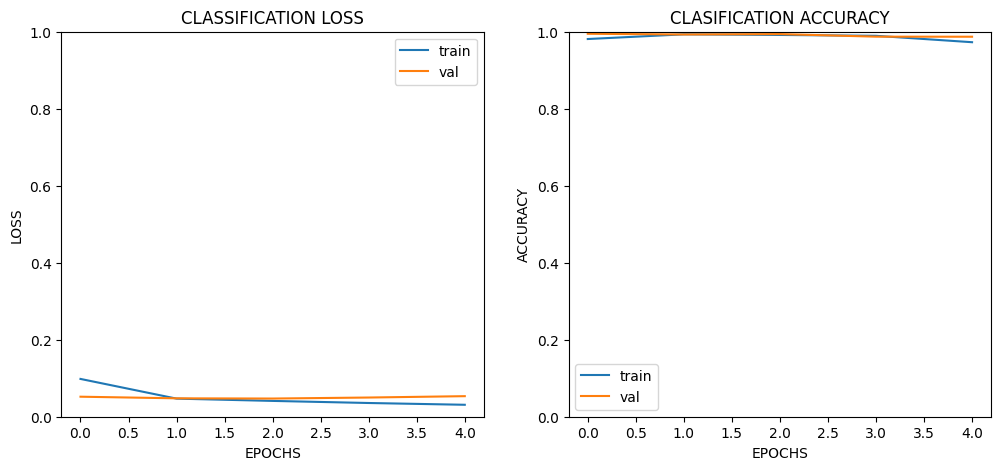

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("CLASSIFICATION LOSS");
plt.ylabel("LOSS");
plt.ylim([0,1.0]);
plt.xlabel("EPOCHS");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("CLASIFICATION ACCURACY");
plt.ylabel("ACCURACY");
plt.ylim([0,1.0]);
plt.xlabel("EPOCHS");
plt.legend(['train', 'val']);

In [ ]:
model.evaluate(X_test,y_test)

998/998 [==============================] - 7s 7ms/step - loss: 0.0542 - accuracy: 0.9857


[0.05416279286146164, 0.9856806993484497]

In [ ]:
model.predict(X_test)

998/998 [==============================] - 7s 7ms/step


array([[4.4869591e-04, 8.0922172e-07, 4.8798276e-05, 8.9700898e-06,
        7.4071162e-05, 4.8108745e-05],
       [2.2091907e-01, 1.0973708e-03, 1.0653411e-02, 8.5903127e-03,
        2.9866328e-02, 5.7556899e-03],
       [2.0097699e-05, 1.0204958e-07, 6.2040085e-06, 5.0883267e-07,
        4.0020859e-06, 4.9368809e-06],
       ...,
       [1.8647449e-03, 2.3592065e-06, 1.2251647e-03, 1.8893073e-06,
        1.7221650e-04, 6.4532014e-06],
       [1.0940953e-04, 2.2185316e-07, 1.2528502e-05, 1.8511012e-06,
        1.5842759e-05, 1.3012699e-05],
       [1.3931794e-04, 8.6433488e-07, 5.2403371e-05, 4.7431454e-06,
        3.1175561e-05, 2.2108079e-05]], dtype=float32)

In [ ]:
text = ["you mother fucker asshole gay shit dumb bitch"]
tokenizer.fit_on_texts(text)
list_tokenized_test = tokenizer.texts_to_sequences(text)
text_X = pad_sequences(list_tokenized_test, maxlen=maxlen)


y_pred = model.predict(text_X)

1/1 [==============================] - 0s 27ms/step


In [ ]:
onearray =  np.ndarray.flatten(y_pred)
onearray



array([0.99948186, 0.52961034, 0.991955  , 0.09220592, 0.91727555,
       0.44973508], dtype=float32)

In [ ]:
for i in range(len(onearray)):
  print('{0:f}'.format(onearray[i]*100))

99.948186
52.961034
99.195498
9.220592
91.727555
44.973508


In [ ]:
model.save('/content/drive/MyDrive/Toxic Classification/model')

In [ ]:
cd  /content/drive/MyDrive/Toxic Classification

/content/drive/MyDrive/Toxic Classification


In [ ]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
print("Completed!")

Completed!


In [ ]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

deb https://ngrok-agent.s3.amazonaws.com buster main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,202 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 https://ngrok-agent.s3.amazonaws.com buster/main amd64 Packages [2,252 B]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,346 kB]
Hit:13 http://ppa.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

--2023-05-29 08:03:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz’

ngrok-stable-linux- 100%[===================>]  13.21M  36.7MB/s    in 0.4s    

2023-05-29 08:03:56 (36.7 MB/s) - ‘ngrok-stable-linux-amd64.tgz’ saved [13856790/13856790]



In [ ]:
!tar -xvf ngrok-stable-linux-amd64.tgz

ngrok


In [ ]:
!ngrok authtoken 2QSPzL4ruo2yD2UZe491w4BPFOY_73tpvhcuP6KosBa5zBS6B

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
